In [1]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import datetime as dt
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\e.sansebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\e.sansebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\e.sansebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\e.sansebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [3]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
pip install stop-words

Note: you may need to restart the kernel to use updated packages.


## Data cleaning and EDA

We proceed to read 6 databases, which we have retrieved from different sources:

Kaggle :

https://www.kaggle.com/datasets/crawlfeeds/trustpilot-reviews-dataset
https://www.kaggle.com/code/darpan25bajaj/bank-reviews-complaint-analysis-using-nlp/data

Web scrapping from Truspilot:


https://www.trustpilot.com/review/expondo.com?sort=recency
https://www.trustpilot.com/review/www.amazon.com?sort=recency
https://www.trustpilot.com/review/www.mowdirect.co.uk?sort=recency

In order to reduce the class inbalance with which we will deal later, we have explicitely scraped neutral reviews from large companies, such as amazon and mowdirect.


In [6]:
expondo_raw = pd.read_csv("./data/expondo_reviews_since_2023.csv")
expondo_raw.head()

,review_id,review_title,review_date,review_rating,review_content,review_location
0,65aed6b600af4883acaf8caf,"TIG (WIG) welder, model S-WIGMA 200PDC",2024-01-22,5,"I ordered a TIG (WIG) / MMA welder, model S-WI...",AT
1,65a68b82126d92f1f9a4d330,Awesome experience,2024-01-15,5,Awesome experience. We had to use their custom...,BG
2,65a3c4680208eaa47b381c4d,The product arrived on time all the…,2024-01-12,5,The product arrived on time all the assembly d...,IE
3,659fcc8b2e14391e7d9d5597,Good and fast delivery,2023-12-27,5,Good and fast delivery of this amazing standin...,CZ
4,659e780423cb48162da0eabb,Bad invoice cross-border purchase - no contact...,2023-12-26,1,Bad invoice - DPH on invoice - shipping to slo...,SK


For the data cleaning we are going to unify the columns from subsequent datasets. We will keep:

- review_title
- review_date
- review_content
- review_rating


In [7]:
expondo_data = expondo_raw.drop(columns = ["review_id","review_location","review_date"],axis=1)

In [8]:
# For later monitoring we are going to identify each dataset, adding a column of source before concatenating them all

expondo_data["source"] = "expondo"

In [9]:
expondo_data.head()

,review_title,review_rating,review_content,source
0,"TIG (WIG) welder, model S-WIGMA 200PDC",5,"I ordered a TIG (WIG) / MMA welder, model S-WI...",expondo
1,Awesome experience,5,Awesome experience. We had to use their custom...,expondo
2,The product arrived on time all the…,5,The product arrived on time all the assembly d...,expondo
3,Good and fast delivery,5,Good and fast delivery of this amazing standin...,expondo
4,Bad invoice cross-border purchase - no contact...,1,Bad invoice - DPH on invoice - shipping to slo...,expondo


In [10]:
expondo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_title    240 non-null    object
 1   review_rating   240 non-null    int64 
 2   review_content  201 non-null    object
 3   source          240 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.6+ KB


In [11]:
bank_raw = pd.read_csv("./data/bank_reviews.csv")

In [12]:
bank_raw.head()

,Title,Content,Date,Rating,Lender
0,Disgusting customer service.,Still waiting for a refund into my bank accoun...,26-Aug-20,1,Vanquis Bank
1,Another poor company with very bad…,Another poor company with very bad customer sk...,26-Aug-20,1,Vanquis Bank
2,I'm very happy with VANQUIS Card,"I'm very happy with VANQUIS Card, 👍",26-Aug-20,5,Vanquis Bank
3,I have been with Vanquis for approx 2…,I have been with Vanquis for approx 2 years an...,26-Aug-20,5,Vanquis Bank
4,Fab app and dead easy to sign up,after asking for and receiving a 2 week break ...,26-Aug-20,5,Vanquis Bank


In [13]:
# We drop the unnecessary columns, rename them according our first df and add the source
bank_data= bank_raw.drop(columns = ["Lender","Date"],axis=1)
bank_data.columns=["review_title","review_content","review_rating"]
bank_data["source"] = "bank"
bank_data.head()

,review_title,review_content,review_rating,source
0,Disgusting customer service.,Still waiting for a refund into my bank accoun...,1,bank
1,Another poor company with very bad…,Another poor company with very bad customer sk...,1,bank
2,I'm very happy with VANQUIS Card,"I'm very happy with VANQUIS Card, 👍",5,bank
3,I have been with Vanquis for approx 2…,I have been with Vanquis for approx 2 years an...,5,bank
4,Fab app and dead easy to sign up,after asking for and receiving a 2 week break ...,5,bank


In [14]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24971 entries, 0 to 24970
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_title    24971 non-null  object
 1   review_content  24971 non-null  object
 2   review_rating   24971 non-null  int64 
 3   source          24971 non-null  object
dtypes: int64(1), object(3)
memory usage: 780.5+ KB


In [15]:
asos_raw= pd.read_csv("./data/ASOS_Trustpilot_13.csv",encoding='latin-1')

In [16]:
asos_raw.head()

,Name,Date,Review_Title,Review_Text,Location,Rating
0,wezwilde,"January 03, 2023",Where do I start?,Where do I start?Moneque in livechat / custome...,GB,Rated 1 out of 5 stars
1,Jordan Ankers,"January 04, 2023",Worst customer service and courier??,Worst customer service and courier service in ...,GB,Rated 1 out of 5 stars
2,Sum,"January 03, 2023",DO NOT USE ASOS,I cannot believe ASOS have hired Evri as a cou...,GB,Rated 1 out of 5 stars
3,Tracey Young,"December 20, 2022",Terrible service,Terrible service. Never received parcel that w...,GB,Rated 1 out of 5 stars
4,adam saumtally,"December 28, 2022",Absolutely rubbish,Absolutely rubbish. Poor customer service. Tel...,GB,Rated 1 out of 5 stars


In [17]:
# We drop the unnecessary columns, rename them according our first df and add the source
asos_data = asos_raw.drop(columns=["Name","Location","Date"])
asos_data.columns=["review_title","review_content","review_rating"]
asos_data["source"] = "asos"
asos_data.head()

,review_title,review_content,review_rating,source
0,Where do I start?,Where do I start?Moneque in livechat / custome...,Rated 1 out of 5 stars,asos
1,Worst customer service and courier??,Worst customer service and courier service in ...,Rated 1 out of 5 stars,asos
2,DO NOT USE ASOS,I cannot believe ASOS have hired Evri as a cou...,Rated 1 out of 5 stars,asos
3,Terrible service,Terrible service. Never received parcel that w...,Rated 1 out of 5 stars,asos
4,Absolutely rubbish,Absolutely rubbish. Poor customer service. Tel...,Rated 1 out of 5 stars,asos


In [18]:
# We create a function to extract the rating as number, since it´s formatted like Rated 1 out of 5 stars

def clean_rating(review_rating):
    match = re.search(r'Rated (\d+) out', review_rating)
    if match:
        return int(match.group(1))
    else:
        return None

In [19]:
# We apply it to the review_rating column

asos_data["review_rating"] = asos_data["review_rating"].apply(clean_rating)
asos_data.head()

,review_title,review_content,review_rating,source
0,Where do I start?,Where do I start?Moneque in livechat / custome...,1,asos
1,Worst customer service and courier??,Worst customer service and courier service in ...,1,asos
2,DO NOT USE ASOS,I cannot believe ASOS have hired Evri as a cou...,1,asos
3,Terrible service,Terrible service. Never received parcel that w...,1,asos
4,Absolutely rubbish,Absolutely rubbish. Poor customer service. Tel...,1,asos


In [20]:
asos_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_title    2020 non-null   object
 1   review_content  1991 non-null   object
 2   review_rating   2020 non-null   int64 
 3   source          2020 non-null   object
dtypes: int64(1), object(3)
memory usage: 63.3+ KB


In [21]:
trustpilot_mix_raw = pd.read_csv("./data/trust_pilot_reviews_data_2022_06.csv")
trustpilot_mix_raw.head()

,name,company_url,trustpilot_url,description,author_name,review_title,review_text,rating,reviewed_at,uniq_id,scraped_at
0,Poundshop,https://www.poundshop.com/,https://uk.trustpilot.com/review/www.poundshop...,"The home for top brands, amazing value! We hav...",Colin,Lowest price in the country,Lowest price in the country for what we wanted...,5,2022-06-18T12:08:09.000Z,7e0edfe9-7251-5561-acc8-34f7d3ab79aa,06/18/22
1,Poundshop,https://www.poundshop.com/,https://uk.trustpilot.com/review/www.poundshop...,"The home for top brands, amazing value! We hav...",Mr Paul Harrison,got it on time they took notice that I…,got it on time they took notice that I let the...,5,2022-06-18T11:48:20.000Z,7e0edfe9-7251-5561-acc8-34f7d3ab79aa,06/18/22
2,Poundshop,https://www.poundshop.com/,https://uk.trustpilot.com/review/www.poundshop...,"The home for top brands, amazing value! We hav...",Mrs Dean,Delivered on time,"Delivered on time. Products as described, pack...",5,2022-06-18T11:32:52.000Z,7e0edfe9-7251-5561-acc8-34f7d3ab79aa,06/18/22
3,Poundshop,https://www.poundshop.com/,https://uk.trustpilot.com/review/www.poundshop...,"The home for top brands, amazing value! We hav...",Mrs Barlow,Quick and efficient service..,Quick and efficient service..Pleased,5,2022-06-18T11:29:27.000Z,7e0edfe9-7251-5561-acc8-34f7d3ab79aa,06/18/22
4,Poundshop,https://www.poundshop.com/,https://uk.trustpilot.com/review/www.poundshop...,"The home for top brands, amazing value! We hav...",Graham Bradbury,Excellent service packed well,Excellent service packed well. Really pleased.,5,2022-06-18T11:22:37.000Z,7e0edfe9-7251-5561-acc8-34f7d3ab79aa,06/18/22


In [22]:
# We drop the unnecessary columns, rename them according our first df and add the source

trustpilot_mix_data = trustpilot_mix_raw.drop(columns = ["name","company_url","trustpilot_url","author_name","uniq_id","scraped_at","reviewed_at","description"],axis=1)
trustpilot_mix_data.columns=["review_title","review_content","review_rating"]
trustpilot_mix_data["source"] = "trustpilot_mix_data"
trustpilot_mix_data.head()

,review_title,review_content,review_rating,source
0,Lowest price in the country,Lowest price in the country for what we wanted...,5,trustpilot_mix_data
1,got it on time they took notice that I…,got it on time they took notice that I let the...,5,trustpilot_mix_data
2,Delivered on time,"Delivered on time. Products as described, pack...",5,trustpilot_mix_data
3,Quick and efficient service..,Quick and efficient service..Pleased,5,trustpilot_mix_data
4,Excellent service packed well,Excellent service packed well. Really pleased.,5,trustpilot_mix_data


In [23]:
trustpilot_mix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_title    3698 non-null   object
 1   review_content  3698 non-null   object
 2   review_rating   3698 non-null   int64 
 3   source          3698 non-null   object
dtypes: int64(1), object(3)
memory usage: 115.7+ KB


In [24]:
# We check the shapes of all df to see that columns match and we will be able to perform the concatenation in a clean way:
display(expondo_data.shape)
display(bank_data.shape)
display(asos_data.shape)
display(trustpilot_mix_data.shape)

(240, 4)

(24971, 4)

(2020, 4)

(3698, 4)

In [25]:
amazon_raw= df = pd.read_excel("./data/amazon_neutral.xlsx")
amazon_raw.head()

,review_id,review_title,review_date,review_rating,review_content,review_location
0,65b115680916f543b1a389a3,Bad experience with marketplace seller,45296,2,"Unfortunately I had a bad experience which, on...",US
1,65afdb177d8134ffaae6549a,I always buy products from Amazon,45292,1,"I always buy products from Amazon, BUT if ther...",US
2,65b02d374f07df2dd9dad8b5,"No help as usual, this time with the new “One ...",45314,1,I buy products but getting any help is incredi...,US
3,65b246b77650506acff6d3b2,Touching rock bottom in 2024,45315,1,Amazon used to provide great service until 202...,GB
4,65b252c6dbd119ab2c125594,Well,45316,4,"Well, y'all lot know what it is. It is the one...",DE


In [26]:
# We drop the unnecessary columns, rename them according our first df and add the source

amazon_data = amazon_raw.drop(columns=["review_id","review_date","review_location"],axis=1)
amazon_data["source"] = "amazon_neutral"
amazon_data.head()

,review_title,review_rating,review_content,source
0,Bad experience with marketplace seller,2,"Unfortunately I had a bad experience which, on...",amazon_neutral
1,I always buy products from Amazon,1,"I always buy products from Amazon, BUT if ther...",amazon_neutral
2,"No help as usual, this time with the new “One ...",1,I buy products but getting any help is incredi...,amazon_neutral
3,Touching rock bottom in 2024,1,Amazon used to provide great service until 202...,amazon_neutral
4,Well,4,"Well, y'all lot know what it is. It is the one...",amazon_neutral


In [27]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_title    820 non-null    object
 1   review_rating   820 non-null    int64 
 2   review_content  764 non-null    object
 3   source          820 non-null    object
dtypes: int64(1), object(3)
memory usage: 25.8+ KB


In [28]:
mowdirect_raw=pd.read_excel("./data/mowdirect_neutral.xlsx")

In [29]:
# We drop the unnecessary columns, rename them according our first df and add the source

mowdirect_data = mowdirect_raw.drop(columns=["review_id","review_date","review_location"],axis=1)
mowdirect_data["source"] = "mowdirect_neutral"
mowdirect_data.head()

,review_title,review_rating,review_content,source
0,Very slow with delivery,3,It was not in stock and it required my husband...,mowdirect_neutral
1,Not a great service,3,"My first mower was lost in transit, this was r...",mowdirect_neutral
2,"Good communcation, ignored",3,Items could not be delivered as specified. Whe...,mowdirect_neutral
3,In many ways a very professional company,3,"When I placed my order, they phoned two days p...",mowdirect_neutral
4,ordered not been sent out.,3,When I first ordered the mower the assistant s...,mowdirect_neutral


In [30]:
mowdirect_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_title    582 non-null    object
 1   review_rating   582 non-null    int64 
 2   review_content  574 non-null    object
 3   source          582 non-null    object
dtypes: int64(1), object(3)
memory usage: 18.3+ KB


In [31]:
# We proceed to concatenate all 6 df:

data = pd.concat([expondo_data, bank_data,asos_data,trustpilot_mix_data,amazon_data,mowdirect_data])

In [32]:
data.head()

,review_title,review_rating,review_content,source
0,"TIG (WIG) welder, model S-WIGMA 200PDC",5,"I ordered a TIG (WIG) / MMA welder, model S-WI...",expondo
1,Awesome experience,5,Awesome experience. We had to use their custom...,expondo
2,The product arrived on time all the…,5,The product arrived on time all the assembly d...,expondo
3,Good and fast delivery,5,Good and fast delivery of this amazing standin...,expondo
4,Bad invoice cross-border purchase - no contact...,1,Bad invoice - DPH on invoice - shipping to slo...,expondo


In [33]:
data.shape

(32331, 4)

In [34]:
# We will pass the review_rating as object/ string, as we want to check for white spaces and also consider them as categorical

data["review_content"] = data["review_content"].astype(str)
data["review_title"] = data["review_title"].astype(str)
data["review_rating"] = data["review_rating"].astype(str)
data.dtypes["review_rating"]

dtype('O')

In [35]:
# We do some exploratory analysis

data.review_rating.unique()

array(['5', '1', '4', '3', '2'], dtype=object)

In [36]:
data.review_rating.isna().sum()

0

In [37]:
# Checking for duplicates
duplicates = data.duplicated()

# Filter the DataFrame to show only the duplicate rows
duplicate_rows = data[duplicates]

# Display the result

print("\nNumber of rows with duplicates:",data.shape[0])
print("\nNumber of duplicated rows ",len(duplicate_rows))
index_duplicates = data[duplicates].index.tolist()
print("\nThe indexes of the duplicated rows are:\n\n",index_duplicates)
data_no_duplicates = data.drop_duplicates()
print("\nNumber of rows without duplicates:",data_no_duplicates.shape[0])


Number of rows with duplicates: 32331

Number of duplicated rows  60

The indexes of the duplicated rows are:

 [41, 47, 48, 56, 59, 69, 76, 88, 140, 155, 19755, 24104, 24126, 24149, 24241, 24290, 24318, 24343, 24401, 24423, 24434, 24499, 24500, 24502, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 1674, 1700, 1797, 2185, 2307, 2350, 2424, 2514, 2628, 2988, 3268, 3462, 3536, 395, 575, 592]

Number of rows without duplicates: 32271


In [38]:
# We reassign the df variable to that without duplicates
data = data_no_duplicates

In [39]:
# We check for NaN values:
data['review_content'].isna().sum()

0

In [40]:
# We proceed to filter out the NaN values
data = data[data['review_content'].isna() == False]
data['review_content'].isna().sum()

0

In [41]:
# We create a copy at this stage of the data df, containing capitals, symbols, icons, emojis, etc., since some of the models seem to perform better with this characteristics
data_uncleaned = data.copy()

In [79]:
data_uncleaned.to_csv("./data/data_uncleaned.csv")

In [42]:
# We create a function to lowercase all the content of the column on a dataset

def lower_case_df(df:pd.DataFrame)-> pd.DataFrame:
    '''
    This function lowercases the content of all the columns inside a df
    input: 
    df to be lowercased
    output:
    content of all columns lowercased
    '''
    df2=df.copy()
    for col in df2.columns:
        df2[col] = df2[col].apply(lambda x: x.lower() if isinstance(x, str) else x)
    return df2
        

In [43]:
# We proceed to lowercase the entire df:

data = lower_case_df(data)

In [44]:
data["review_rating"].value_counts()

review_rating
5    24136
1     3688
4     2199
3     1836
2      412
Name: count, dtype: int64

In [45]:
# We create a cleaning function to clean the text data and have a version of the df lowercased and without special characters:

def clean_up(s):
    """
    Cleans up numbers, URLs, and special characters from a string.

    Args:
        s: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    s = s.lower()
    s = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ', s)
    s= re.sub(r'\d+',' ',s) # Replace one or more digits by  ' '
    s = re.sub(r'\W+',' ',s) # Replace everything non-alpahnumeric by ' '
    s = BeautifulSoup(s, 'lxml').get_text().strip()

    return s

In [46]:
# We apply the previous function to the 2 text columns:

data["review_content"] = data["review_content"].apply(lambda x: clean_up(x))
data["review_title"] = data["review_title"].apply(lambda x: clean_up(x))

In [48]:
# Data shape before checking if white spaces on texts columns:
print("Rows before checking if white spaces on texts columns:", data.shape[0])

Rows before checking if white spaces on texts columns: 32271


In [53]:
empty_values_content = data['review_content'].eq('') | data['review_content'].eq(' ') | data['review_content'].eq('  ') | data['review_content'].str.isspace()

In [54]:
empty_values_title = data['review_title'].eq('') | data['review_title'].eq(' ') | data['review_title'].eq('  ') | data['review_title'].str.isspace()

In [55]:
empty_values_rating = data['review_rating'].eq('') | data['review_rating'].eq(' ') | data['review_rating'].eq('  ') | data['review_rating'].str.isspace()

In [49]:
print("Sum of empty values on the title are:",empty_values_title.sum())
print("Sum of empty values on the review content are:",empty_values_content.sum())
print("Sum of empty values on the review rating are:",empty_values_rating.sum())

Sum of emmpty values on the title are: 37
Sum of emmpty values on the review content are: 5
Sum of emmpty values on the review rating are: 0


In [56]:
data.drop(data[empty_values_title].index, inplace=True)

In [57]:
data.drop(data[empty_values_content].index, inplace=True)

C:\Users\e.sansebastian\AppData\Local\Temp\ipykernel_26724\1536672269.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.drop(data[empty_values_content].index, inplace=True)


In [58]:
data.drop(data[empty_values_rating].index, inplace=True)

C:\Users\e.sansebastian\AppData\Local\Temp\ipykernel_26724\3951574863.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.drop(data[empty_values_rating].index, inplace=True)


In [60]:
# Data shape after removing white spaces on texts columns:
print("Rows after checking if white spaces on texts columns:", data.shape[0])

Rows after checking if white spaces on texts columns: 32200


In [61]:
# We store a cleaned version of the cleaned data before checking the class balance
data.to_csv("./data/df_premodel.csv",index=False,sep=";")

## Checking class balance

In [62]:
# In order to proceed with the data modelling to be able to better predict the sentiment, we are going to check and deal with the class balancing, if necessary.
# Before checking the class balance we are going to see how many reviews we have from each source and rating:

source_rating_breakdown = data.groupby(["source", "review_rating"]).size().reset_index(name='count')
source_rating_breakdown

,source,review_rating,count
0,amazon_neutral,1,15
1,amazon_neutral,2,2
2,amazon_neutral,3,793
3,amazon_neutral,4,1
4,amazon_neutral,5,2
5,asos,1,1796
6,asos,2,120
7,asos,3,77
8,bank,1,1231
9,bank,2,211


In [63]:
# having a look at the distribution of reviews and the potential class inbalance on the neutral and negative reviews (1-3 stars)
# we will simply filter out the 5 star ratings from the bank dataset, with which we will still have over 5 K positive reviews

In [64]:
data = data[~((data["source"] == "bank") & (data["review_rating"] == "5"))]

In [65]:
data.shape

(11043, 4)

In [66]:
# Since we want to measure the sentiment as positive, neutral and negative, we are going to group the ratings as follows:

# 4-5 -> positive
# 3 -> neutral
# 1-2 -> negative

In [67]:
data['sentiment'] = data['review_rating'].apply(lambda x: 'negative' if x in ['1', '2'] else ('neutral' if x == '3' else 'positive'))

C:\Users\e.sansebastian\AppData\Local\Temp\ipykernel_26724\3518821174.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['review_rating'].apply(lambda x: 'negative' if x in ['1', '2'] else ('neutral' if x == '3' else 'positive'))


In [68]:
sentiment_breakdown = data.groupby("sentiment").size().reset_index(name='count')
sentiment_breakdown

,sentiment,count
0,negative,4091
1,neutral,1827
2,positive,5125


C:\Users\e.sansebastian\OneDrive - Expondo\Ironhack\Weeks\Week_9\Final_project\final_project\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\e.sansebastian\OneDrive - Expondo\Ironhack\Weeks\Week_9\Final_project\final_project\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\e.sansebastian\OneDrive - Expondo\Ironhack\Weeks\Week_9\Final_project\final_project\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a 

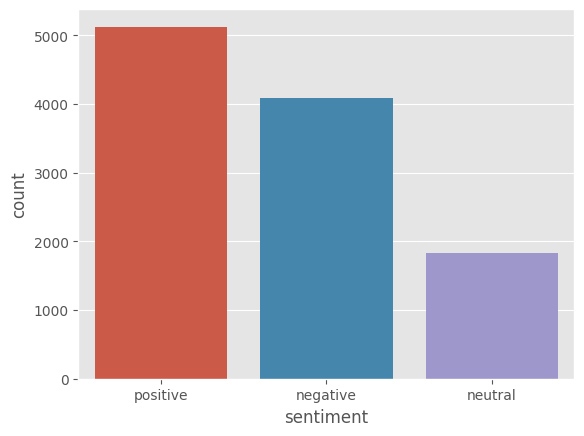

sentiment
positive    0.464095
negative    0.370461
neutral     0.165444
Name: count, dtype: float64


The class imbalance ratio is: 0.11


C:\Users\e.sansebastian\AppData\Local\Temp\ipykernel_26724\2580573833.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\nThe class imbalance ratio is: {:.2f}".format((count_classes[0]-count_classes[1])/(count_classes[0]+count_classes[1])))


In [69]:
# We plot the column sentiment, which is the one we want to predict. On the plot we can see a clear class imbalance for the positive sentiment
sns.countplot(x='sentiment', data=data,hue="sentiment");
plt.show()
display(data["sentiment"].value_counts()/len(data["sentiment"]))
count_classes = data['sentiment'].value_counts()
print("\nThe class imbalance ratio is: {:.2f}".format((count_classes[0]-count_classes[1])/(count_classes[0]+count_classes[1])))

In [70]:
data.head()

,review_title,review_rating,review_content,source,sentiment
0,tig wig welder model s wigma pdc,5,i ordered a tig wig mma welder model s wigma p...,expondo,positive
1,awesome experience,5,awesome experience we had to use their custome...,expondo,positive
2,the product arrived on time all the,5,the product arrived on time all the assembly d...,expondo,positive
3,good and fast delivery,5,good and fast delivery of this amazing standin...,expondo,positive
4,bad invoice cross border purchase no contact t...,1,bad invoice dph on invoice shipping to slovaki...,expondo,negative


In [71]:
# having a decent amount of positives and negatives, we proceed to oversample, to increase the neutral class and generate enough samples

In [72]:
# We split the df to process the oversampling

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

X = data  # Adjust if needed
y = data['sentiment']

# Apply RandomOverSampler to balance the classes
oversampler = RandomOverSampler(random_state=42)
data_resampled, y_resampled = oversampler.fit_resample(X, y)

In [73]:
data_resampled

,review_title,review_rating,review_content,source,sentiment
0,tig wig welder model s wigma pdc,5,i ordered a tig wig mma welder model s wigma p...,expondo,positive
1,awesome experience,5,awesome experience we had to use their custome...,expondo,positive
2,the product arrived on time all the,5,the product arrived on time all the assembly d...,expondo,positive
3,good and fast delivery,5,good and fast delivery of this amazing standin...,expondo,positive
4,bad invoice cross border purchase no contact t...,1,bad invoice dph on invoice shipping to slovaki...,expondo,negative
...,...,...,...,...,...
15370,crappy product not fit for purpose,3,factory tightened bolts couldn t untighten,mowdirect_neutral,neutral
15371,beware,3,great place to buy products if dealing directl...,amazon_neutral,neutral
15372,product is fine and delivered in a,3,product is fine and delivered in a timely fash...,mowdirect_neutral,neutral
15373,a very professional supplier,3,i found the crossover to a professional suppli...,trustpilot_mix_data,neutral


In [74]:
y_resampled_df=pd.DataFrame(y_resampled)

In [75]:
y_resampled.value_counts()

sentiment
positive    5125
negative    5125
neutral     5125
Name: count, dtype: int64

C:\Users\e.sansebastian\OneDrive - Expondo\Ironhack\Weeks\Week_9\Final_project\final_project\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\e.sansebastian\OneDrive - Expondo\Ironhack\Weeks\Week_9\Final_project\final_project\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\e.sansebastian\OneDrive - Expondo\Ironhack\Weeks\Week_9\Final_project\final_project\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a 

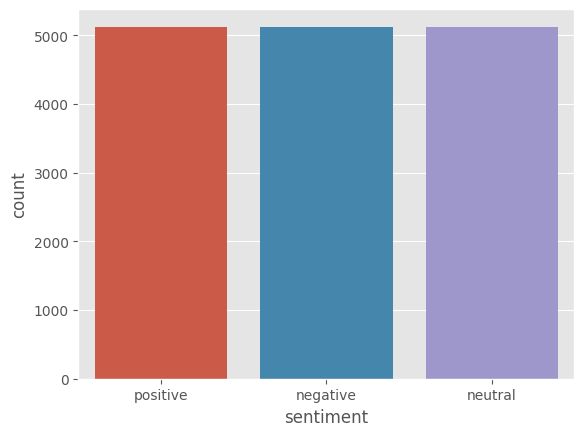

sentiment
positive    0.333333
negative    0.333333
neutral     0.333333
Name: count, dtype: float64


 The new class imbalance ratio after the oversampling is: 0.00


C:\Users\e.sansebastian\AppData\Local\Temp\ipykernel_26724\3146444488.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("\n The new class imbalance ratio after the oversampling is: {:.2f}".format((count_classes[0]-count_classes[1])/(count_classes[0]+count_classes[1])))


In [76]:
# We plot the column sentiment, which is the one we want to predict. On the plot we can see a clear class imbalance for the positive sentiment
sns.countplot(x='sentiment', data=y_resampled_df,hue="sentiment");
plt.show()
display(y_resampled_df["sentiment"].value_counts()/len(y_resampled_df["sentiment"]))
count_classes = y_resampled_df['sentiment'].value_counts()
print("\n The new class imbalance ratio after the oversampling is: {:.2f}".format((count_classes[0]-count_classes[1])/(count_classes[0]+count_classes[1])))

In [77]:
# We save a version of the resampled df:

data_resampled.to_csv("data_resampled.csv",index=False)